I want to improve the dataset loader, as in its current form it is not allowing to have random transformations when caching

Result: fail... it's t straightforward to generate a dataloader of events before ToFrame

The alternative is to use pytorch transforms post caching

In [28]:
import os
import numpy as np
import tonic.datasets as datasets
import tonic.transforms as transforms
from snn_delays.config import DATASET_PATH, CACHE_PATH
from snn_delays.datasets.transforms_tonic import *
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset
from tonic import MemoryCachedDataset
from snn_delays.utils.memory_cached_dataset import MemoryCachedDataset
import os
np.random

class TonicDataset:

    PATH = DATASET_PATH

    def __init__(self, dataset_name, sensor_size_to=None,
                 crop_to=None, one_polarity=False, merge_polarity=False, 
                 random_crop_to=None):

        # Initialization of attributes
        self.dataset_name = dataset_name
        self.train_dataset = None
        self.test_dataset = None

        # Set parameters for transformations
        parameter_dataset= {
            'shd': {'n_classes': 20,
                    'sensor_size': datasets.SHD.sensor_size},
            'ssc': {'n_classes': 35,
                    'sensor_size': datasets.SSC.sensor_size},
            'nmnist': {'n_classes': 10,
                    'sensor_size': datasets.NMNIST.sensor_size},
            'ibm_gestures': {'n_classes': 11,
                    'sensor_size': datasets.DVSGesture.sensor_size},
            'smnist': {'n_classes': 10,
                    'sensor_size': (99, 1, 1)},
            'stmnist': {'n_classes': 10,
                    'sensor_size': (10,10,2)},
            'lipsfus': {'n_classes': 10,
                    'sensor_size': (256, 1, 1)}
        }
        self.n_classes = parameter_dataset[self.dataset_name]['n_classes']
        #self.duration_ms = parameter_dataset[self.dataset_name]['duration_ms']

        original_sensor_size = \
            parameter_dataset[self.dataset_name]['sensor_size']

        # Initialize transformations
        list_sample_transform = list()
        #list_label_transform = list()

        # Sensor size and down-sampling factor
        sensor_size_list = list(original_sensor_size)
        spatial_factor = None

        if sensor_size_to is not None:
            if self.dataset_name in ['nmnist', 'ibm_gestures']:
                sensor_size_list[0:-1] = \
                    [sensor_size_to] * (len(sensor_size_list) - 1)
                target_size = (sensor_size_to, sensor_size_to)
            else:
                sensor_size_list[0] = sensor_size_to
                target_size = (sensor_size_to, 1)

            if self.dataset_name != 'smnist':
                spatial_factor = \
                    np.asarray(target_size) / original_sensor_size[:-1]

        # Crop transformation
        if crop_to is not None:
            list_sample_transform.append(
                transforms.CropTime(0, crop_to))
            
        # Random crop transformation
        if random_crop_to is not None:
            #duration = 2e6 # shd
            #duration = 500000 # shd
            max_start = random_crop_to[0]
            duration = random_crop_to[1]
            list_sample_transform.append(CropTimeRandom(max_start, duration))

        # Merge polarity transformation
        if merge_polarity:
            sensor_size_list[-1] = 1
            list_sample_transform.append(transforms.MergePolarities())

        # One polarity transformation
        if one_polarity:
            sensor_size_list[-1] = 1
            list_sample_transform.append(OnePolariy())

        # Define final sensor size
        self.sensor_size = tuple(sensor_size_list)

        # Down-sampling transformation
        if spatial_factor is not None:
            list_sample_transform.append(
                transforms.Downsample(spatial_factor=spatial_factor[0]))
            
        # Define final transformations
        # list_sample_transform.append(
        #     transforms.ToFrame(
        #         sensor_size=self.sensor_size, n_time_bins=self.total_time))
        
        print(list_sample_transform)
        print("YEAH")

        self.sample_transform = transforms.Compose(list_sample_transform)
        self.label_transform = transforms.ToOneHotEncoding(n_classes=self.n_classes)

    def get_train_attributes(self):

        # Calculate the number of inputs using the sensor size
        num_input = 1
        for x in self.sensor_size:
            num_input *= x

        # Create the dictionary
        train_attrs = {'num_input': num_input,
                       'num_training_samples': len(self.train_dataset),
                       'num_output': self.n_classes}

        return train_attrs


class SHDDataset(TonicDataset):

    def __init__(self, dataset_name='shd', **kwargs):
        super().__init__(dataset_name=dataset_name,
                         **kwargs)
        
        # Train and test dataset definition
        self.train_dataset = datasets.SHD(
            save_to=self.PATH,
            train=True,
            transform=self.sample_transform,
            target_transform=self.label_transform)

        self.test_dataset = datasets.SHD(
            save_to=self.PATH,
            train=False,
            transform=self.sample_transform,
            target_transform=self.label_transform)

class DatasetLoader:

    def __init__(self, dataset='shd', caching='disk', num_workers=0,
                 batch_size=256, **kwargs):

        super(DatasetLoader, self).__init__()

        # Set attributes for inputs
        self.dataset = dataset
        self.batch_size = batch_size
        #self.total_time = total_time

        # Define available tonic datasets
        tonic_datasets = ['shd', 'shd_multicrop', 'ssc', 'nmnist','stmnist',
                          'nmnist784', 'ibm_gestures', 'smnist', 'lipsfus']

        # Generate train and test datasets
        if dataset in tonic_datasets:

            if dataset == 'shd':
                from snn_delays.datasets.tonic_datasets import SHDDataset
                _dataset = SHDDataset(
                    dataset_name=dataset, **kwargs)

            # Get dataset dictionary
            self.dataset_dict = _dataset.get_train_attributes()
            train_dataset = _dataset.train_dataset
            test_dataset = _dataset.test_dataset

            #expose tonic dataset
            self._dataset = _dataset
                       
        # Add the dataset and classes (optionally) names to the dictionary
        self.dataset_dict['dataset_name'] = dataset

        if 'crop_to' in kwargs:
            self.dataset_dict['time_ms'] = kwargs['crop_to']/1000
        elif 'random_crop_to' in kwargs:
            self.dataset_dict['time_ms'] = kwargs['random_crop_to'][-1]/1000
        else:
            self.dataset_dict['time_ms'] = False

        if 'mnist' in dataset or 'shd' in dataset:
            self.dataset_dict['class_names'] = [
                'zero, one, two, three, four, five, six, seven, eight, nine']

        # Check that the dataset is correctly created
        assert train_dataset is not None, \
            "[ERROR]: Dataset not found, check available options at " \
            "utils/loaders.py or examples/03_Load_a_dataset.ipynb."

        # Set dataset attributes
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset


        #print(type(test_dataset.data))

        # pin memory if caching is not GPU
        pin_memory = True

        # Select caching option
        if caching == 'disk':
            train_cache_path = os.path.join(
                CACHE_PATH,
                'cache_train_{}_{}'.format(dataset)+ '_'.join(str(value) for value in kwargs.values()))
            test_cache_path = os.path.join(
                CACHE_PATH,
                'cache_test_{}_{}_'.format(dataset)+'_'.join(str(value) for value in kwargs.values()))

            train_dataset = DiskCachedDataset(train_dataset,
                                              cache_path=train_cache_path)
            test_dataset = DiskCachedDataset(test_dataset,
                                             cache_path=test_cache_path)
        elif caching == 'memory':
            train_dataset = MemoryCachedDataset(train_dataset)
            test_dataset = MemoryCachedDataset(test_dataset)
        elif caching == 'gpu':
            train_dataset = MemoryCachedDataset(train_dataset, device="cuda:0")
            test_dataset = MemoryCachedDataset(test_dataset, device="cuda:0")
            pin_memory = False
        else:
            pass

        # Define train and test loader using DataLoader from torch
        self.train_loader = DataLoader(train_dataset,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       drop_last=False,
                                       pin_memory=pin_memory,
                                       num_workers=num_workers)

        self.test_loader = DataLoader(test_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=False,
                                      pin_memory=pin_memory,
                                      num_workers=num_workers)

    def change_total_time(self, time):
        self.total_time = time
        print(f'[INFO] Total_time changed to {time}')

    def get_dataloaders(self):
        return self.train_loader, self.test_loader, self.dataset_dict



In [29]:
dataset = 'shd'
tt = 10
batch_size = 1024

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='gpu',
                  num_workers=0,
                  batch_size=batch_size,
                  crop_to=1e6)

[CropTime(min=0, max=1000000.0), ToFrame(sensor_size=(700, 1, 1), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]


In [30]:
train_loader, test_loader, dataset_dict = DL.get_dataloaders()

In [31]:
for x, y in test_loader:
    print(x)
    break

tensor([[[[0, 0, 0,  ..., 1, 0, 1]],

         [[0, 0, 0,  ..., 0, 1, 1]],

         [[0, 0, 0,  ..., 1, 0, 1]],

         ...,

         [[0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0]],

         ...,

         [[0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0]],

         ...,

         [[0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0]]],


        ...,


        [[[0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 1,  ..., 0, 0, 0]],

         ...,

         [[0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0]]],


     

trying a post-caching transform. spatio-temporal noise!

In [118]:
import torch
import torch.nn.functional as F

class SpatioTemporalConvolutionNoise:
    def __init__(self, kernel_size=3, noise_std=0.1):
        """
        Args:
            kernel_size (int or tuple): Size of the 3D convolution kernel (e.g., 3 for a 3x3x3 kernel).
            noise_std (float): Standard deviation of the random kernel values.
        """
        self.kernel_size = kernel_size
        self.noise_std = noise_std

    def __call__(self, tensor):
        """
        Args:
            tensor (torch.Tensor): Input tensor of shape [batch_size, num_timesteps, 1, num_inputs].
        Returns:
            torch.Tensor: Tensor with added spatio-temporal noise.
        """
        batch_size, num_timesteps, _, num_inputs = tensor.shape

        # # Generate a random 3D convolution kernel with zero-sum weights
        # if isinstance(self.kernel_size, int):
        #     kernel_size = (self.kernel_size,) * 3  # e.g., (3, 3, 3)
        # else:
        #     kernel_size = self.kernel_size

        kernel_size = (self.kernel_size, 1, self.kernel_size)

        # kernel = torch.randn(1, 1, *kernel_size, device=tensor.device) * self.noise_std
        # kernel = kernel / torch.sum(kernel)  # Ensure the kernel sums to one

        # identity
        # kernel = torch.zeros(1, 1, *kernel_size, device=tensor.device)
        # kernel[0, 0, 1, 1, 1] = 1.0

        kernel = torch.randn(1, 1, *kernel_size, device=tensor.device)
        kernel *= 0.2 / kernel.sum()

        idx1 = np.random.randint(self.kernel_size)
        idx2 = np.random.randint(self.kernel_size)

        kernel[0, 0, idx1, 0, idx2] = 0.8

        # n = torch.tensor(self.kernel_size).prod().item()
        # # Generate noise for n-1 elements, scaled to sum to 0.2.
        # noise = torch.rand(n - 1, device=tensor.device)
        # noise *= 0.2 / noise.sum()

        # # Create a flat kernel and choose a random index for the 0.8 value.
        # kernel = torch.empty(n, device=tensor.device)
        # idx = torch.randint(0, n, (1,))
        # kernel[idx] = 0.8

        # # Fill the rest with noise
        # mask = torch.ones(n, dtype=torch.bool, device=tensor.device)
        # mask[idx] = False
        # kernel[mask] = noise

        # n = torch.tensor(self.kernel_size).prod().item()
        # kernel = torch.rand(1, 1, *kernel_size)
        # kernel *= 0.2 / kernel.sum()

        # # Create flat kernel and pick a random index for the 0.8
        # #kernel = torch.empty(n, device=tensor.device)
        # idx = torch.randint(0, n, (1,))

        # print(idx)

        # kernel[idx] = 0.8
        
        print(torch.sum(kernel))
        print(kernel)

        # Reshape tensor to [batch_size, 1, num_timesteps, 1, num_inputs] for 3D convolution
        tensor_reshaped = tensor.unsqueeze(1)  # Add a channel dimension: [batch_size, 1, num_timesteps, 1, num_inputs]

        # Apply 3D convolution
        padding = tuple(k // 2 for k in kernel_size)  # Padding to maintain input size
        noisy_tensor = F.conv3d(tensor_reshaped, kernel, padding=padding)

        #noisy_tensor = F.conv3d(tensor_reshaped, kernel)

        # Remove the extra channel dimension and reshape back to original shape
        noisy_tensor = noisy_tensor.squeeze(1)  # [batch_size, num_timesteps, 1, num_inputs]

        return noisy_tensor

# Example usage
batch_size = 32
num_timesteps = 10
num_inputs = 5
#dummy_batch = torch.randn(batch_size, num_timesteps, 1, num_inputs)  # Example input
dummy_batch = x.float()  # Example input

# Create the transform
transform = SpatioTemporalConvolutionNoise(kernel_size=10, noise_std=0.1)

# Apply the transform
noisy_batch = transform(dummy_batch)

# Verify that the sum of the transformed sample is approximately the same as the original
print("Sum of original batch:", torch.sum(dummy_batch).item())
print("Sum of noisy batch:", torch.sum(noisy_batch).item())

tensor(1.0006, device='cuda:0')
tensor([[[[[ 2.0979e-02, -2.8925e-02,  3.9723e-02, -5.0705e-02,  1.3982e-02,
            -2.1346e-02,  3.1827e-02,  2.4443e-02, -3.1521e-02,  2.4895e-02]],

          [[ 1.6092e-02,  2.4387e-02, -8.1669e-03,  9.5975e-03, -2.1817e-02,
            -1.3203e-03, -2.7336e-02,  2.9045e-02,  2.5714e-02, -1.1763e-02]],

          [[-2.6469e-02,  6.9809e-04, -2.3734e-02,  6.4558e-03, -4.0356e-03,
            -3.0397e-02,  1.7698e-03, -3.4656e-02,  2.7921e-02,  1.6069e-05]],

          [[ 3.9859e-02, -6.2495e-03,  1.6033e-02,  6.4758e-03, -2.4993e-02,
            -9.1505e-03,  3.8394e-02, -1.0978e-02,  1.2540e-02,  3.1351e-03]],

          [[ 6.6195e-03, -8.2492e-03, -3.2304e-02, -7.2703e-03, -6.8397e-03,
             3.7772e-03,  3.9224e-03, -2.4666e-02,  2.1715e-02,  1.8139e-02]],

          [[-3.7506e-02, -5.8063e-03,  3.2704e-02,  2.7361e-02, -3.1693e-03,
            -1.1040e-03,  1.8719e-02,  3.4379e-02, -5.6306e-02, -1.5342e-02]],

          [[ 3.0976e-02, -

In [119]:
x[0].shape

torch.Size([50, 1, 700])

In [120]:
noisy_batch[0].shape

torch.Size([51, 1, 701])

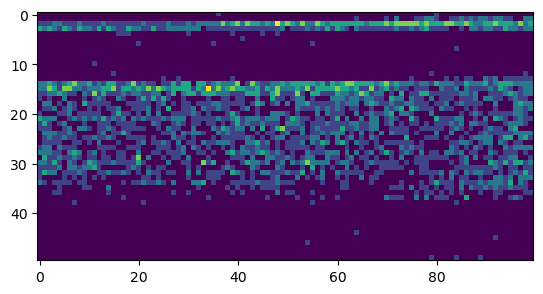

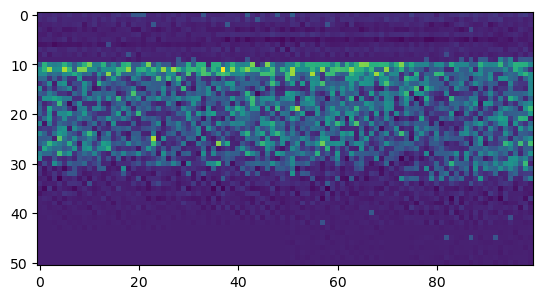

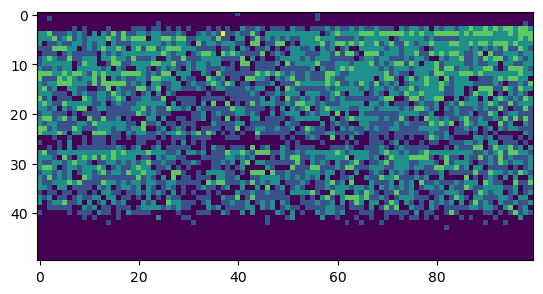

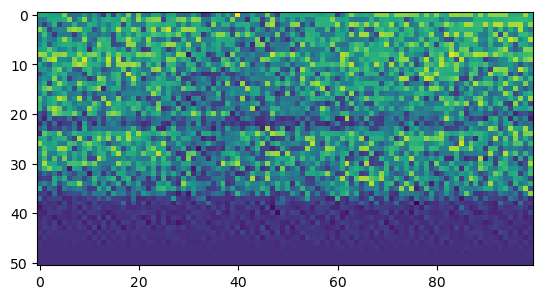

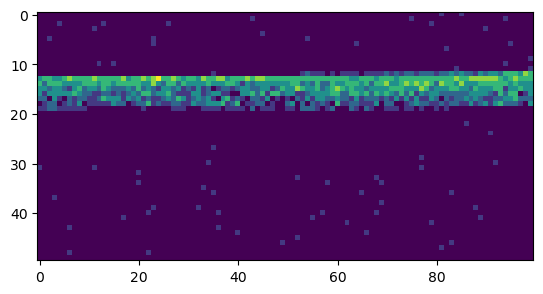

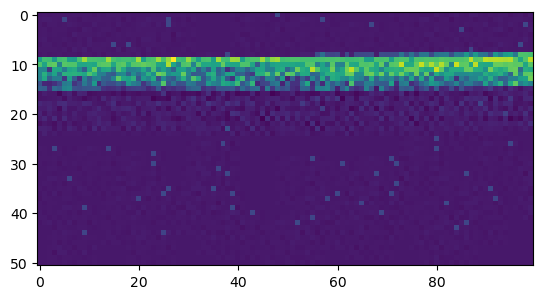

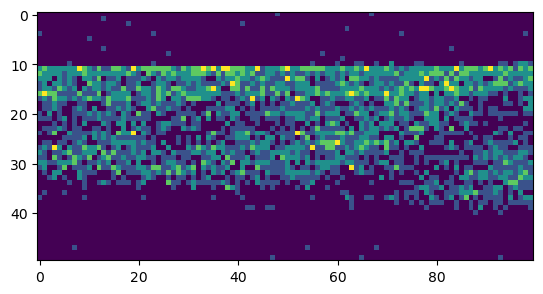

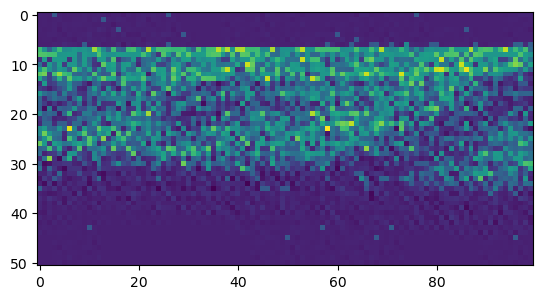

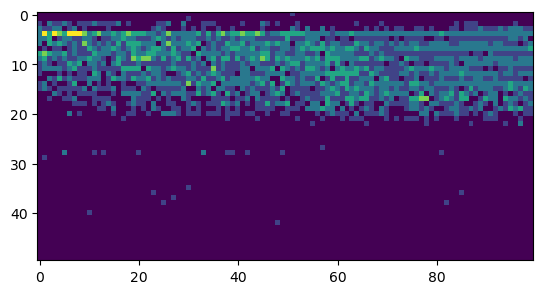

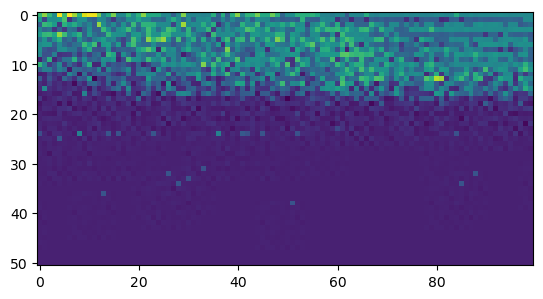

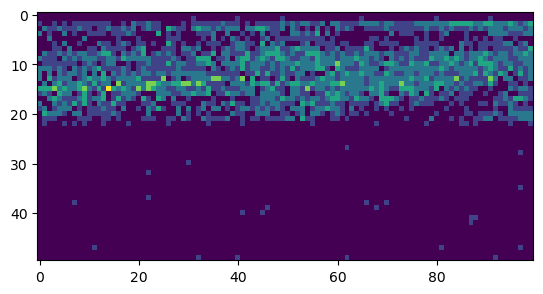

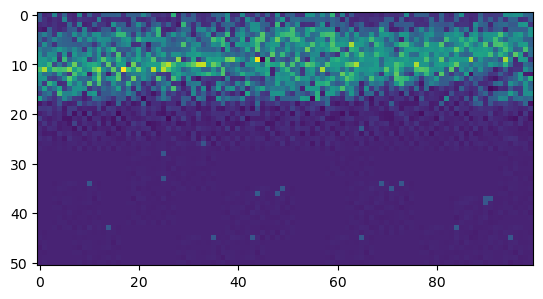

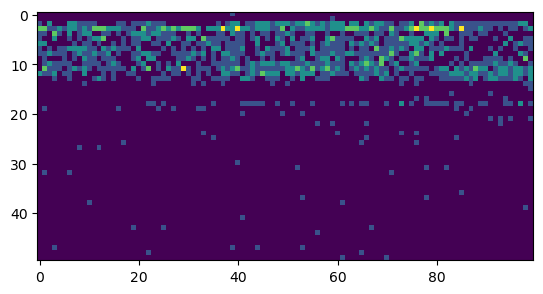

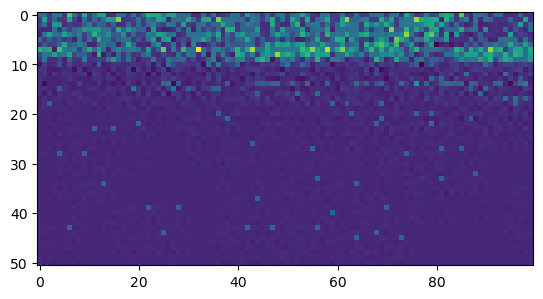

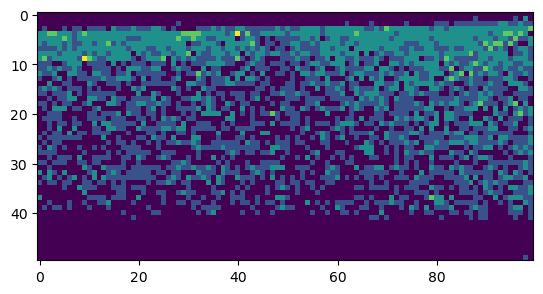

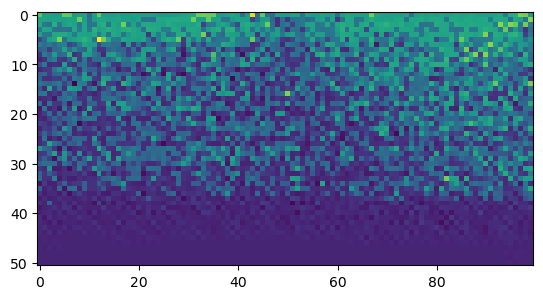

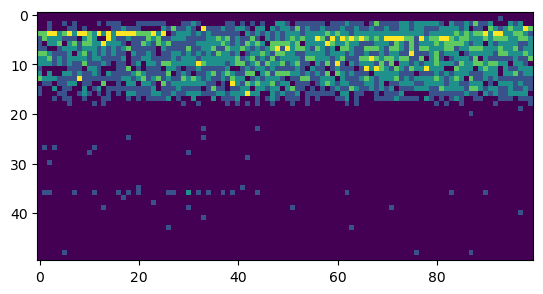

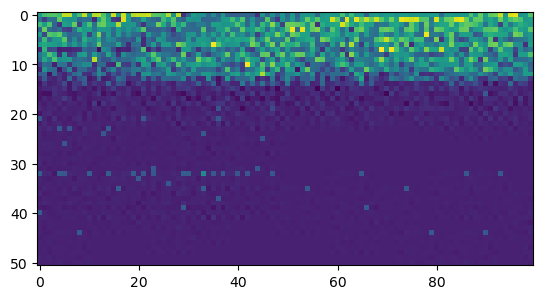

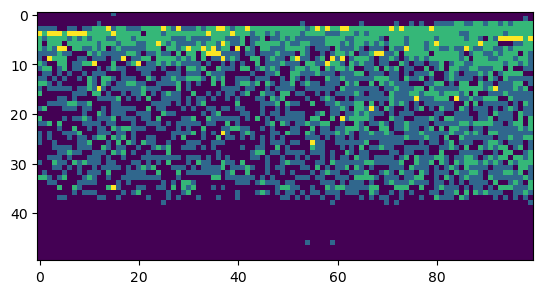

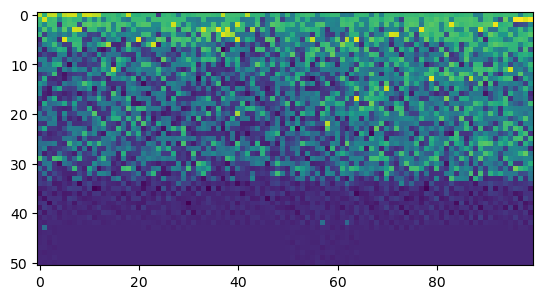

In [121]:
import matplotlib.pyplot as plt

for s in range(10):
    plt.imshow(x[s][:, 0, 500:600].cpu().numpy())
    plt.show()
    plt.imshow(noisy_batch[s][:, 0, 500:600].cpu().numpy())
    plt.show()

In [65]:
kernel = torch.rand(1, 1, 3, 3, 3)

In [67]:
kernel[0]

tensor([[[[0.7677, 0.5122, 0.2926],
          [0.0728, 0.1166, 0.6985],
          [0.5550, 0.7956, 0.2655]],

         [[0.5555, 0.2197, 0.9415],
          [0.4625, 0.8069, 0.6521],
          [0.0480, 0.2166, 0.1623]],

         [[0.7211, 0.3122, 0.2501],
          [0.8399, 0.9353, 0.2424],
          [0.1075, 0.8532, 0.7603]]]])

In [73]:
idx = torch.randint(0, 9, (1,))
idx

tensor([8])

In [117]:
np.random.randint(19)

17